In [578]:
# Import libraries to be used.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import floor

from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import SCORERS

In [579]:
# Define a random state value
RANDOM_STATE = 3030

In [580]:
# Define column names which will be used instead of the ones in the datasets.
column_names = [
    "age", "sex", "chest_pain_type", "rest_bp", "cholesterol",
    "fasting_bs", "resting_ecg", "max_hr", "exercise_angina", "st_exercise_depression",
    "st_exercise_slope", "major_vessels_fluorospy", "thal", "angiographic_disease"
]
na_values = ["?"] # Define what values will be interpreted as missing values, in this dataset the "?" character is used for this.

# Load all datasets using relative paths and combine into one dataframe.
df = pd.concat([
    pd.read_csv("../data/processed.cleveland.data", names=column_names, na_values=na_values),
    pd.read_csv("../data/processed.hungarian.data", names=column_names, na_values=na_values),
    pd.read_csv("../data/processed.switzerland.data", names=column_names, na_values=na_values),
    pd.read_csv("../data/processed.va.data", names=column_names, na_values=na_values)
]).drop(['st_exercise_slope', 'major_vessels_fluorospy', 'thal'], axis=1)

In [581]:
df[df["angiographic_disease"] > 1] = 1

In [582]:
df['age'].fillna((df['age'].mean()), inplace=True)
df['rest_bp'].fillna((df['rest_bp'].mean()), inplace=True)
df['cholesterol'].fillna((df['cholesterol'].mean()), inplace=True)
df['max_hr'].fillna((df['max_hr'].mean()), inplace=True)
df['st_exercise_depression'].fillna((df['st_exercise_depression'].mean()), inplace=True)
df = df.apply(lambda x:x.fillna(x.value_counts().index[0]))

In [583]:
# Set category attributes
df["sex"] = df["sex"].astype("category")
df["chest_pain_type"] = df["chest_pain_type"].astype("category")
df["fasting_bs"] = df["fasting_bs"].astype("category")
df["resting_ecg"] = df["resting_ecg"].astype("category")
df["exercise_angina"] = df["exercise_angina"].astype("category")
df["angiographic_disease"] = df["angiographic_disease"].astype("category")

In [584]:
X = MinMaxScaler().fit_transform(df.drop(["angiographic_disease"], axis=1).to_numpy())
Y = df["angiographic_disease"].to_numpy()


In [585]:
df2=df.drop(["angiographic_disease"], axis=1)
df2

,age,sex,chest_pain_type,rest_bp,cholesterol,fasting_bs,resting_ecg,max_hr,exercise_angina,st_exercise_depression
0,63.0,1.0,1.0,145.000000,233.0,1.0,2.0,150.000000,0.0,2.300000
1,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.000000,1.0,1.000000
2,67.0,1.0,4.0,120.000000,229.0,0.0,2.0,129.000000,1.0,2.600000
3,37.0,1.0,3.0,130.000000,250.0,0.0,0.0,187.000000,0.0,3.500000
4,41.0,0.0,2.0,130.000000,204.0,0.0,2.0,172.000000,0.0,1.400000
...,...,...,...,...,...,...,...,...,...,...
195,54.0,0.0,4.0,127.000000,333.0,1.0,1.0,154.000000,0.0,0.000000
196,62.0,1.0,1.0,95.288613,139.0,0.0,1.0,103.095829,1.0,0.743665
197,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.000000,1.0,1.000000
198,58.0,1.0,4.0,95.288613,385.0,1.0,2.0,103.095829,1.0,0.743665


In [586]:
knn = KNeighborsClassifier(n_neighbors=15)

In [587]:
scores_result = {}
for i in range(1,6): 
    k=i*2
    bestk = SelectKBest(chi2, k=k).fit(X, Y)
    X_new=bestk.transform(X)
    scores = cross_validate(knn, X_new, Y, cv=5, scoring=["roc_auc", "f1_macro", "accuracy", "precision", "recall"])
    scores_result[k]={}
    scores_result[k]["AUC"] = np.mean(scores["test_roc_auc"])
    scores_result[k]["F1"] = np.mean(scores["test_f1_macro"])
    scores_result[k]["Accuracy"] = np.mean(scores["test_accuracy"])
    scores_result[k]["Precision"] = np.mean(scores["test_precision"])
    scores_result[k]["Recall"] = np.mean(scores["test_recall"])
    bestk.get_feature_names_out(input_features=df2.columns) 
    selected_features = bestk.get_feature_names_out(input_features=df2.columns)
    dfk=df[selected_features]
    print("Running 5-CV with {} features={}".format(k, selected_features))
    print("Scores: AUC {} F1 {} Accuracy {} Precision {} Recall {}\n".format(scores_result[k]["AUC"], scores_result[k]["F1"], scores_result[k]["Accuracy"],scores_result[k]["Precision"],scores_result[k]["Recall"] ) )



Running 5-CV with 2 features=['fasting_bs' 'exercise_angina']
Scores: AUC 0.8256397195526712 F1 0.7405941562201978 Accuracy 0.7521739130434782 Precision 0.9186447951273534 Recall 0.6404387497573286

Running 5-CV with 4 features=['rest_bp' 'fasting_bs' 'max_hr' 'exercise_angina']
Scores: AUC 0.8537940945137711 F1 0.7949910992241007 Accuracy 0.7989130434782609 Precision 0.8670572016987472 Recall 0.7701417200543583

Running 5-CV with 6 features=['age' 'rest_bp' 'cholesterol' 'fasting_bs' 'max_hr' 'exercise_angina']
Scores: AUC 0.8329513360058414 F1 0.7841001736813782 Accuracy 0.7923913043478261 Precision 0.8552463567205386 Recall 0.7858668219763152

Running 5-CV with 8 features=['age' 'sex' 'chest_pain_type' 'rest_bp' 'cholesterol' 'fasting_bs'
 'max_hr' 'exercise_angina']
Scores: AUC 0.8936095918540705 F1 0.7908832575760647 Accuracy 0.7978260869565217 Precision 0.8509944139566243 Recall 0.7975732867404387

Running 5-CV with 10 features=['age' 'sex' 'chest_pain_type' 'rest_bp' 'cholestero

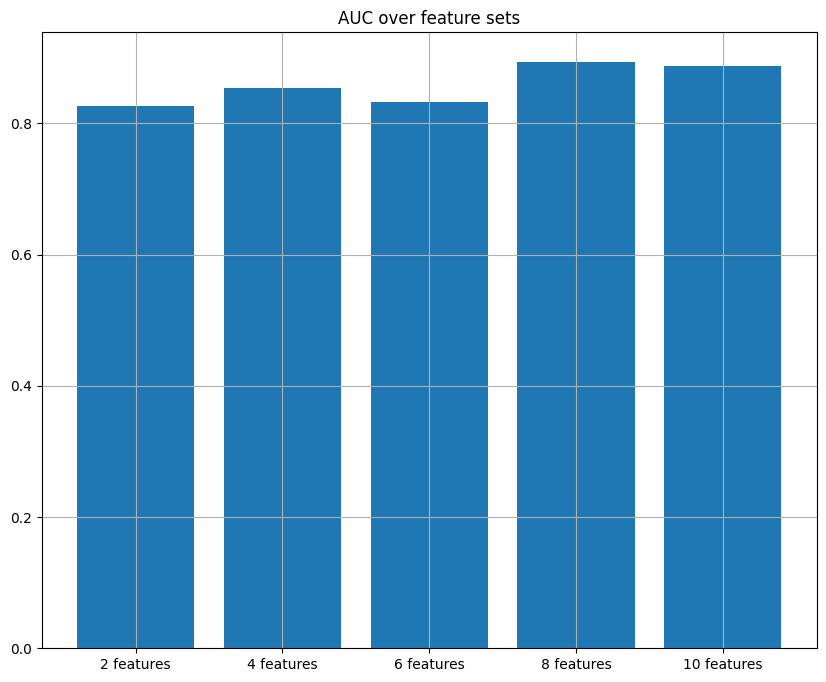

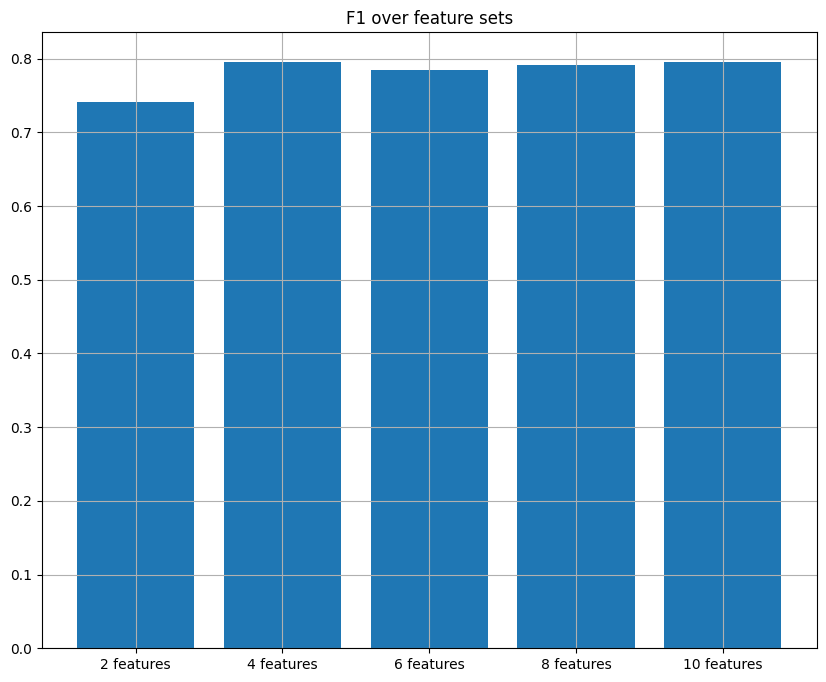

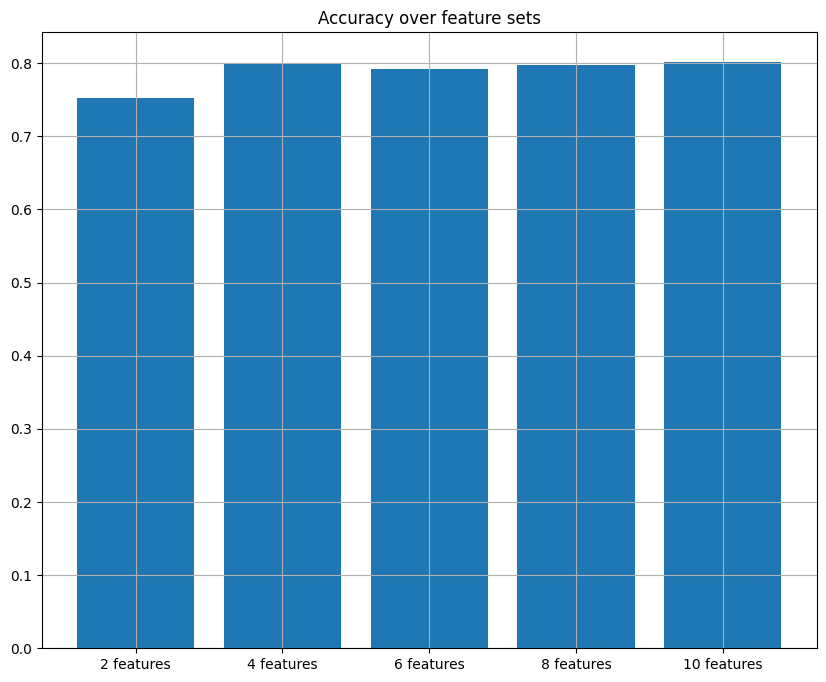

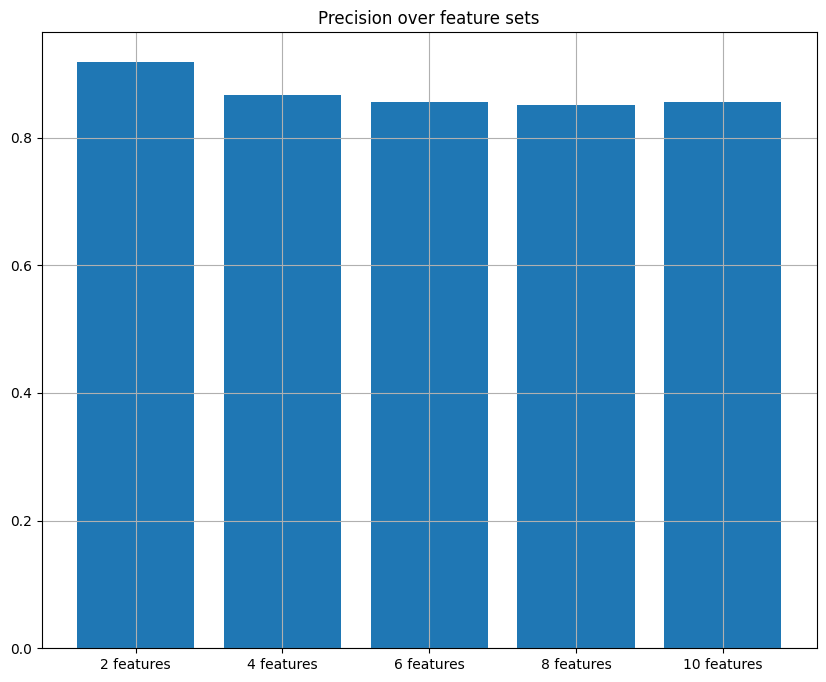

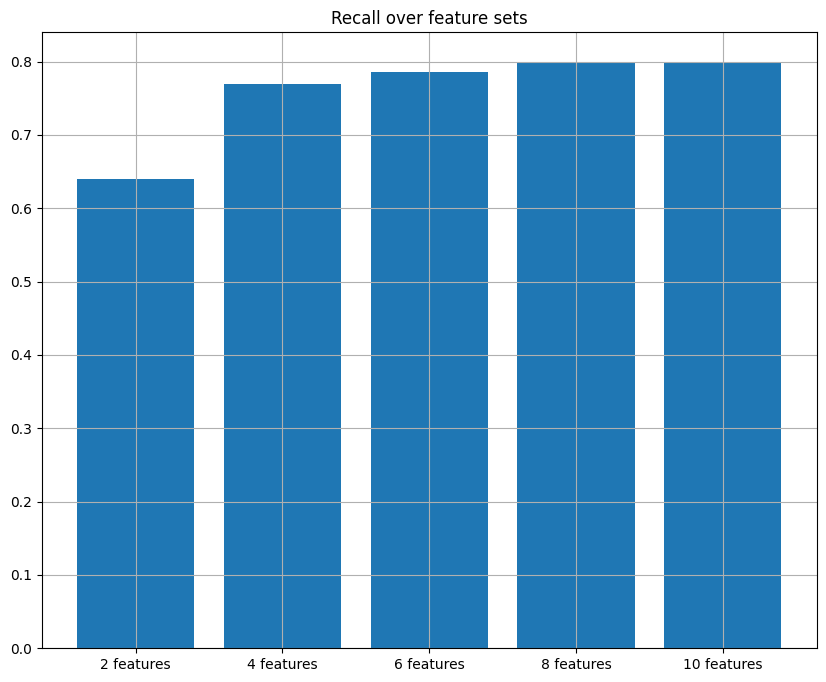

In [592]:
scores_to_plot = {}
for score_name in ["AUC", "F1", "Accuracy", "Precision", "Recall"]:
    scores_to_plot[score_name] = {}
    for feat_set in scores_result.keys():
        scores_to_plot[score_name][str(feat_set) + " features"] = round(scores_result[feat_set][score_name], 3)
    plt.figure(figsize=(10, 8))
    plt.title("{} over feature sets".format(score_name))
    plt.grid()
    plt.bar(scores_to_plot[score_name].keys(), scores_to_plot[score_name].values())

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=RANDOM_STATE)

In [ ]:
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X=X_train, y=Y_train)


KNeighborsClassifier(n_neighbors=15)